In [66]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import model as md
import time
import pickle

$\| \nabla f(t^k) \|_2 * 2\|t^0 - t^k\|_2 $

$2\|t^0 - t^k\|_2$

$5\|t^0\|_2$

In [67]:
np.version.version

'1.18.2'

In [68]:
net_name = 'SiouxFalls_net.tntp'
trips_name = 'SiouxFalls_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, 
                                  columns=['init_node', 
                                           'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
graph_table = graph_data['graph_table']
n = np.max(graph_table['init_node'].to_numpy())

In [69]:
graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,True,2,True,25900.200640,6.0
1,1,True,3,True,23403.473190,4.0
2,2,True,1,True,25900.200640,6.0
3,2,True,6,True,4958.180928,5.0
4,3,True,1,True,23403.473190,4.0


In [20]:
def costs_func(df, i, j, column):
    rows = df.loc[df['init_node'] == i]
    columns = rows.loc[df['term_node'] == j]
    c = columns[column]
    print(rows)
    try:
        c = int(c)
        return c
    except TypeError: # если не пересекается район i с районом j
        return np.nan

def create_T(df):
    T = np.full((n, n), np.nan, dtype=np.double)
    
    i_matrix = df['init_node'].to_numpy()
    j_matrix = df['term_node'].to_numpy()
    
    for i in i_matrix:
        for j in j_matrix:
            data = df.loc[(df['init_node'] == i) & 
                             (df['term_node'] == j)]
            if not data.empty:
                T[i-1][j-1] = data['free_flow_time'].to_numpy()[0]
    return T

def create_cor_matr(dictnr):
    correspondence_matrix = np.full((n, n), np.nan, dtype=np.double)
    i = 1
    if n > 1:
        for key in dictnr.keys(): #dictnr[i].keys()
            for k, v in zip(dictnr[i]['targets'], dictnr[i]['corrs']):
                correspondence_matrix[key - 1][k - 1] = v # костыль!
            i += 1
    else:
        for key in dictnr.keys():
            for k, v in zip(dictnr[i][key].keys(), dictnr[i][key].values()):
                correspondence_matrix[int(key) - 1][int(k)] = v
    # print('corr mtrx: ', correspondence_matrix)
    return correspondence_matrix

In [21]:
correspondence_matrix = create_cor_matr(graph_correspondences)

In [22]:
correspondence_matrix

array([[   0.,  100.,  100.,  500.,  200.,  300.,  500.,  800.,  500.,
        1300.,  500.,  200.,  500.,  300.,  500.,  500.,  400.,  100.,
         300.,  300.,  100.,  400.,  300.,  100.],
       [ 100.,    0.,  100.,  200.,  100.,  400.,  200.,  400.,  200.,
         600.,  200.,  100.,  300.,  100.,  100.,  400.,  200.,    0.,
         100.,  100.,    0.,  100.,    0.,    0.],
       [ 100.,  100.,    0.,  200.,  100.,  300.,  100.,  200.,  100.,
         300.,  300.,  200.,  100.,  100.,  100.,  200.,  100.,    0.,
           0.,    0.,    0.,  100.,  100.,    0.],
       [ 500.,  200.,  200.,    0.,  500.,  400.,  400.,  700.,  700.,
        1200., 1400.,  600.,  600.,  500.,  500.,  800.,  500.,  100.,
         200.,  300.,  200.,  400.,  500.,  200.],
       [ 200.,  100.,  100.,  500.,    0.,  200.,  200.,  500.,  800.,
        1000.,  500.,  200.,  200.,  100.,  200.,  500.,  200.,    0.,
         100.,  100.,  100.,  200.,  100.,    0.],
       [ 300.,  400.,  300.,  400.,

In [23]:
df = graph_data['graph_table']
df[df['init_node'] == 1].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,True,2,True,25900.20064,6.0
1,1,True,3,True,23403.47319,4.0


In [24]:
print(df['init_node'].unique())
print(np.sort(df['term_node'].unique()))
print(df['free_flow_time'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[ 6.  4.  5.  2.  3. 10.  8.]


In [25]:
df.head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,True,2,True,25900.200640,6.0
1,1,True,3,True,23403.473190,4.0
2,2,True,1,True,25900.200640,6.0
3,2,True,6,True,4958.180928,5.0
4,3,True,1,True,23403.473190,4.0


In [27]:
T = create_T(df)
np.savetxt('T.csv', T, delimiter=',')

In [30]:
T[0][1]

6.0

In [31]:
def distributor_L_W(array):
    max_value = np.max(array)
    max_value_index = np.where(array == np.max(array))
    
    unique, counts = np.unique(array, return_counts=True)
    array_dict = dict(zip(unique, counts))
    try:
        zero_num = array_dict[0]
    except KeyError:
        print('this array without 0')
        return array
    array[max_value_index] = max_value - zero_num
    for index in np.where(array == 0)[0]:
        array[index] = 1.0
    
    return array

    def get_t_from_shortest_distances(self, n, graph_data):

        targets = []
        df = graph_data['graph_table']
        T = None
        i = 0
        for source in range(n):

            targets = [source]
            targets += range(0, n)

            graph_table = graph_data['graph_table']

            graph = tg.TransportGraph(graph_table,
                                      graph_data['links number'],
                                      graph_data['nodes number'])


            t_exp = np.array(df['free_flow_time'], dtype='float64').flatten()
            distances, pred_map = graph.shortest_distances(source=source,
                                                           targets=targets,
                                                           times=t_exp)

            if i == 0:
                T = distances[1:]
            else:
                T = np.vstack([T, distances[1:]])
            targets = []
            i += 1

        return T

def _index_nodes(self, graph_table, graph_correspondences):
    table = graph_table.copy()
    inits = np.unique(table['init_node'][table['init_node_thru'] == False])
    terms = np.unique(table['term_node'][table['term_node_thru'] == False])
    through_nodes = np.unique([table['init_node'][table['init_node_thru'] == True],
                                   table['term_node'][table['term_node_thru'] == True]])

    nodes = np.concatenate((inits, through_nodes, terms))
    nodes_inds = list(zip(nodes, np.arange(len(nodes))))
    init_to_ind = dict(nodes_inds[: len(inits) + len(through_nodes)])
    term_to_ind = dict(nodes_inds[len(inits):])

    table['init_node'] = table['init_node'].map(init_to_ind)
    table['term_node'] = table['term_node'].map(term_to_ind)
    correspondences = {}
    for origin, dests in graph_correspondences.items():
        dests = copy.deepcopy(dests)
        correspondences[init_to_ind[origin]] = {'targets': list(map(term_to_ind.get, dests['targets'])),
                                                    'corrs': dests['corrs']}

    inds_to_nodes = dict(zip(range(len(nodes)), nodes))
    return inds_to_nodes, correspondences, table

def get_T_from_t(self, t, graph_data, graph_correspondences):

    result = {}
    result['zone travel times'] = {}

    import transport_graph as tg

    inds_to_nodes, graph_correspondences_, graph_table_ = self._index_nodes(graph_data['graph_table'],
                                                                                   graph_correspondences)

    # print('data handler: ', len(inds_to_nodes), graph_data['links number'])
    graph_dh = tg.TransportGraph(graph_table_, len(inds_to_nodes), graph_data['links number'])

    for source in graph_correspondences_:

        targets = graph_correspondences_[source]['targets']
        travel_times, _ = graph_dh.shortest_distances(source, targets, t)
        # print('in model.py, travel_times: ', travel_times)
        # mapping nodes' indices to initial nodes' names:
        source_nodes = [inds_to_nodes[source]] * len(targets)
        target_nodes = list(map(inds_to_nodes.get, targets))
        result['zone travel times'].update(zip(zip(source_nodes, target_nodes), travel_times))

    return result

In [33]:
T_dict = handler.get_T_from_t(graph_data['graph_table']['free_flow_time'],  graph_data, graph_correspondences)  # np.array([[0.0, 0.5], [0.5, 0.0]]) #
T = np.full((n, n), np.inf)
for key in T_dict['zone travel times'].keys():
    T[key[0] - 1][key[1] - 1] = T_dict['zone travel times'][key]

In [34]:
T

array([[ 0.,  6.,  4.,  8., 10., 11., 16., 13., 15., 18., 14.,  8., 11.,
        18., 23., 18., 20., 18., 22., 22., 18., 20., 17., 15.],
       [ 6.,  0., 10., 11.,  9.,  5., 10.,  7., 14., 16., 17., 14., 17.,
        21., 19., 12., 14., 12., 16., 16., 22., 21., 23., 21.],
       [ 4., 10.,  0.,  4.,  6., 10., 15., 12., 11., 14., 10.,  4.,  7.,
        14., 19., 17., 19., 17., 21., 20., 14., 16., 13., 11.],
       [ 8., 11.,  4.,  0.,  2.,  6., 11.,  8.,  7., 10.,  6.,  8., 11.,
        10., 15., 13., 15., 13., 17., 17., 18., 18., 14., 15.],
       [10.,  9.,  6.,  2.,  0.,  4.,  9.,  6.,  5.,  8.,  8., 10., 13.,
        12., 14., 11., 13., 11., 15., 15., 19., 17., 16., 17.],
       [11.,  5., 10.,  6.,  4.,  0.,  5.,  2.,  9., 11., 12., 14., 17.,
        16., 14.,  7.,  9.,  7., 11., 11., 17., 16., 20., 20.],
       [16., 10., 15., 11.,  9.,  5.,  0.,  3., 12.,  9., 14., 19., 19.,
        17., 12.,  5.,  7.,  2.,  9.,  6., 12., 11., 15., 15.],
       [13.,  7., 12.,  8.,  6.,  2.,  3.

##### Подумаем над T
В данных по Москве время в минутах. В этих данных время по часам! ('Time: hours, distance: miles'). Переведём их в минуты. Также T занулённое, там, где стоят nan, поставим по 100 часов

In [35]:
L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)
people_num = np.nansum(L)

L = distributor_L_W(L)
W = distributor_L_W(W)

L = L / np.nansum(L)
W = W / np.nansum(W)
print('people_num: ', people_num)

this array without 0
this array without 0
people_num:  360600.0


In [36]:
np.count_nonzero(~np.isnan(T))

576

In [37]:
def Sinkhorn(k, lambda_W_prev, lambda_L_prev):    
    lambda_L = np.full((n, ), 0.0, dtype=np.double)
    lambda_W = np.full((n, ), 0.0, dtype=np.double)
    
    if k % 2 == 0:
        lambda_W = lambda_W_prev
        lambda_L = np.log(np.nansum(
            (np.exp(-lambda_W_prev - 1 - cost_matrix)).T 
            / L, axis = 0
            ))
    else:
        lambda_L = lambda_L_prev
        lambda_W = np.log(np.nansum(
            (np.exp(-lambda_L - 1 - cost_matrix.T)).T
            / W, axis=0
            ))
        
    return lambda_W, lambda_L

def iterate(cost_matrix, L, W, num_iter, eps):
    
    lambda_L = np.full((n, ), 0.0, dtype=np.double)
    lambda_W = np.full((n, ), 0.0, dtype=np.double)
    
    for k in range(num_iter):
        
        lambda_Wn, lambda_Ln = Sinkhorn(k, lambda_W, lambda_L)
        
        delta = np.linalg.norm(np.concatenate((lambda_Ln - lambda_L, 
                                               lambda_Wn - lambda_W)))
        
        lambda_L, lambda_W = lambda_Ln, lambda_Wn 
        
        if delta < eps:
            break
    
    r = rec_d_i_j(lambda_Ln, lambda_Wn, cost_matrix)
    return r

def rec_d_i_j(lambda_L, lambda_W, cost_matrix):
    er = np.exp( -1 - cost_matrix - (np.reshape(lambda_L, (n, 1)) + lambda_W))
    return er * people_num

In [59]:
num_iter = 2500
alpha, beta = 1.0, 1.0
alpha_range  = np.arange(0.0, 1.0, 0.0001)

best_matrix = None
min_reconstruction_error = np.inf
best_alpha, best_beta = np.nan, np.nan

er_list = []

for alpha_idx in range(len(alpha_range)):
    alpha = alpha_range[alpha_idx]
    cost_matrix = np.nan_to_num(T ** beta * alpha, nan=100)

    rec = iterate(cost_matrix, L, W, num_iter, eps=10**(-3))    
    er = np.linalg.norm(rec - np.nan_to_num(correspondence_matrix, nan=0.0))
    er_list.append(er)

    if er < min_reconstruction_error:
        min_reconstruction_error = er
        best_alpha = alpha_range[alpha_idx]
        best_matrix = rec

        print(
            'alpha= ', best_alpha
            )

alpha=  0.0
alpha=  0.0001
alpha=  0.0002
alpha=  0.00030000000000000003
alpha=  0.0004
alpha=  0.0005
alpha=  0.0006000000000000001
alpha=  0.0007
alpha=  0.0008
alpha=  0.0009000000000000001
alpha=  0.001
alpha=  0.0011
alpha=  0.0012000000000000001
alpha=  0.0013000000000000002
alpha=  0.0014
alpha=  0.0015
alpha=  0.0016
alpha=  0.0017000000000000001
alpha=  0.0018000000000000002
alpha=  0.0019
alpha=  0.002
alpha=  0.0021000000000000003
alpha=  0.0022
alpha=  0.0023
alpha=  0.0024000000000000002
alpha=  0.0025
alpha=  0.0026000000000000003
alpha=  0.0027
alpha=  0.0028
alpha=  0.0029000000000000002
alpha=  0.003
alpha=  0.0031000000000000003
alpha=  0.0032
alpha=  0.0033
alpha=  0.0034000000000000002
alpha=  0.0035
alpha=  0.0036000000000000003
alpha=  0.0037
alpha=  0.0038
alpha=  0.0039000000000000003
alpha=  0.004
alpha=  0.0041
alpha=  0.004200000000000001
alpha=  0.0043
alpha=  0.0044
alpha=  0.0045000000000000005
alpha=  0.0046
alpha=  0.0047
alpha=  0.0048000000000000004
al

In [60]:
er_list[0] - min_reconstruction_error

9.915203526012192

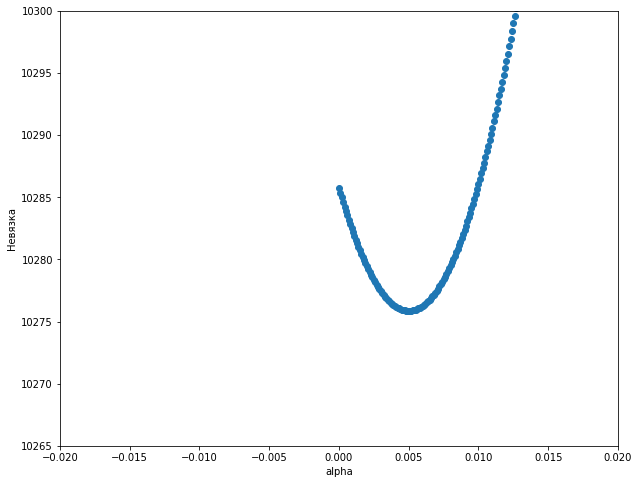

In [64]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(alpha_range, er_list)
# plt.ylim(0, 2)
plt.ylim(10265, 10300)
plt.xlim(-0.02, 0.02)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()
fig.savefig('best_sink_gamma' + str(len(alpha_range)) + '.png')

In [65]:
print(n / np.nansum(T))

0.003837543971858011


##### Best recovery corr matrix  

In [ ]:
for line in best_matrix:
    print(line)

In [ ]:
for line in correspondence_matrix:
    print(line)

##### Multi-stage

In [ ]:
def matrix_to_dict(corr_matrix):
    d = {}
    list_of_dict = []
    n = np.shape(corr_matrix)[0]
    buf_l = []
    buf_ind = []
    for i in range(1, n + 1):
        
        for j in range(1, n + 1):
            buf_ind.append(int(j))
            buf_l.append(float(corr_matrix[i-1][j-1]))
            
        if i in d:
            d[i].append(dict(zip(buf_ind, buf_l)))
        else:
            d[i] = dict(zip(buf_ind, buf_l))
            
        buf_ind = []
        buf_l = []
    
#     print(list_of_dict)
    return d

In [ ]:
best_correcpondences_dict = matrix_to_dict(best_matrix)

In [ ]:
model = md.Model(graph_data, best_correcpondences_dict, 
                 total_od_flow, mu = 0, rho = 0.15)

In [ ]:
for i, eps_abs in enumerate(np.logspace(1,3,1)):
    print(i, eps_abs)

In [ ]:
max_iter = 10000

for i, eps_abs in enumerate(np.logspace(1,3,1)):
    
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustf', 
                                    solver_kwargs = solver_kwargs, 
                                    verbose = False)

In [ ]:
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
print('Time ratio =', np.max(result
                                ['times'] / graph_data['graph_table']
                                ['Free Flow Time']))
print('Flow excess =', np.max(result
                                ['flows'] / graph_data['graph_table']
                                ['Capacity']) - 1, end = '\n\n')

In [ ]:
result['times']